# Learning

In [14]:
import collections, math, random, time

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('minimal')

from scipy.stats import norm

import numpy as np

In [15]:
def bernoulli(p): return 1*(random.random() < p)

def plogpq(p, q):
    if p == 0:
        return 0
    if q == 0:
        return math.inf
    return p * math.log(p/q)

def kldiv(p, q): 
    return plogpq(p, q) + plogpq(1-p, 1-q)

def newton(f, fp, x, eps=1e-5, projection=lambda x: x):
    while True:
        xn = projection(x - f(x)/fp(x))
        print(xn)
        if abs(xn - x) < eps:
            return xn
        x = xn
        
def proj_unit(x): return max(0, min(1, x))

def bisect_fn(fn, lowerbound, upperbound, eps=1e-4):
    if fn(lowerbound) > 0:
        return bisect_fn(lambda x: -fn(x), lowerbound, upperbound)
    
    assert fn(upperbound) > 0, "LB and UB must have opposing signs"
    
    while abs(upperbound - lowerbound) > eps:
        midpoint = lowerbound/2 + upperbound/2
        if fn(midpoint) > 0:
            upperbound = midpoint
        else:
            lowerbound = midpoint
            
    return lowerbound/2 + upperbound/2

In [16]:
History = collections.namedtuple("History", "s n")

def update_history(history, outcome):
    return History(history.s + outcome, history.n + 1)

def mean(history):
    if history.n > 0:
        return history.s / history.n
    return 0

def ucb_index(history, t, K, alpha=2):
    if history.n == 0: return 1e10 + random.random()
    return mean(history) + math.sqrt(alpha * math.log(t) / (2 * history.n))

def moss_index(history, t, K):
    if history.n == 0: return 1e10 + random.random()
    return mean(history) + math.sqrt(max(math.log(t/(K*history.n)), 0) / history.n)

def greedy_index(history, t, K):
    if history.n == 0: return 1e10 + random.random()
    return mean(history)

def thompson_index(history, t, K, a=1, b=1):
    return random.betavariate(a + history.s, b + history.n - history.s)

def klucb_index(history, t, K, c=0):
    if history.n == 0: return 1e10 + random.random()
    phat = mean(history)
    
    if phat == 1:
        return 1
        
    f = lambda q: kldiv(phat, q) - (math.log(t) + c * math.log(math.log(t))) / history.n
    
    # Based on bisection
    return bisect_fn(f, phat, 1)
    
    # Based on Newton's method
    # fp = lambda q: -phat/max(1e-5, q) + (phat-1)/max(q-1, 1e-5)
    # return newton(f, fp, phat/2 + 1/2, projection=proj_unit)
    

def index_policy(histories, index, *args):
    t = sum(history.n for history in histories) + 1
    K = len(histories)
    return max(range(K), key=lambda i: index(histories[i], t, K, *args))

def ucb(histories): return index_policy(histories, ucb_index)
def moss(histories): return index_policy(histories, moss_index)
def greedy(histories): return index_policy(histories, greedy_index)
def thompson(histories): return index_policy(histories, thompson_index)
def klucb(histories): return index_policy(histories, klucb_index)

In [17]:
def max_concave(f, xmin=0, xmax=1, eps=1e-10):
    """ find the maximum of a 1d concave function on a bdd interval"""
    m = xmin/2 + xmax/2
    if m - xmin < eps:
        return m
    
    fmin, fm, fmax = f(xmin), f(m), f(xmax)

    if fm > fmin and fm > fmax:
        return max((max_concave(f, m, xmax), max_concave(f, xmin, m)), 
                   key=lambda x: f(x))
    
    if fm < fmin:
        return max_concave(f, xmin, m)

    return max_concave(f, m, xmax)

In [26]:
def bandit(policy, pull, K, T):
    histories = [History(0, 0) for _ in range(K)]
    actions = []

    for t in range(T):
        action = policy(histories)
        outcome = pull(action)
        histories[action] = update_history(histories[action], outcome)
        actions.append(action)
        
    return actions, histories

def best_action_value(F, r):
    p = lambda x: r(x) * (1-F(x))

    xstar = max_concave(p)
    M = p(xstar)
    return xstar, M

def abandonment_pulls(K, F, r):
    def pull(action):
        x = (action + 1)/K
        return r(x) * bernoulli(1-F(x))
    
    return pull

def listify(gen):
    "Convert a generator into a function which returns a list"
    def patched(*args, **kwargs):
        return list(gen(*args, **kwargs))
    return patched

@listify
def abandonment_regret(actions, F, r, M=0):
    p = lambda x: r(x) * (1-F(x))
        
    R = 0
    for action in actions:
        R += M - p(action)
        yield R

In [19]:
def plot_regrets(regrets, ax=None, title="Regret plot", style="k-"):
    if ax is None:
        f, ax = plt.subplots()
    
    nrep = len(regrets)
    T = len(regrets[0])
    
    for R in regrets:
        line, = ax.plot(R, style, alpha=0.2 + 1/nrep)
    
    line.set_label(title)
        
    ax.set_title(title)
    ax.set_xlabel("mean regret: {:.1f}".format(sum(R[-1] for R in regrets)/nrep))
    ax.set_xlim(0, T)
    
def plot_actions(actions, ax=None):
    if ax is None:
        f, ax = plt.subplots()
        
    ax.imshow(actions.T, aspect="auto")
    ax.tick_params(axis='both',
                which='both',
                bottom='off',
                top='off',
                left='off',
                labelbottom='off',
                labelleft='off')

In [20]:
def abandonment_simulation(T, K, F, r, policy, nrep=1, action_agg=20):    
    pull = abandonment_pulls(K, F, r)
    regrets = []
    action_matrix = np.zeros((T//action_agg, K))
    
    xstar, M = best_action_value(F, r)
    
    for _ in range(nrep):
        actions, histories = bandit(policy, pull, K, T)
        R = abandonment_regret([(i+1)/K for i in actions], F, r, M)
        
        # record regret
        regrets.append(R)
        # record actions
        for t, a in enumerate(actions):
            action_matrix[t//action_agg][a] += 1
        
    return regrets, action_matrix

In [22]:
import heapq
import bisect

import numpy as np

In [23]:
class ECDF:
    def __init__(self):
        self.data = []
        
    def observe(self, x):
        bisect.insort(self.data, x)
        
    def evaluate(self, x):
        n = len(self.data)
        if n == 0:
            return 0.5
        return bisect.bisect(self.data, x) / n
    
    def ecdf(self):
        n = len(self.data)
        if n < 200:
            return ((x, i/n) for i, x in enumerate(self.data))
        return ((x, self.evaluate(x)) 
                for x in np.linspace(self.data[0], self.data[-1], 100))
    
    def plot(self):
        x, e = zip(*self.ecdf())
        
        f, ax = plt.subplots()
        ax.plot(x, e)
        ax.set_title("Empirical CDF")
        ax.set_xlabel(r"$x$")
        ax.set_ylabel(r"$\hat F(x)$")

In [24]:
def oracle(T, r, sampler=random.random):
    ecdf = ECDF()
    actions = []
    for _ in range(T):
        action = max(np.linspace(0, 1, random.randint(100, 200)), 
                     key=lambda x: r(x) * (1-ecdf.evaluate(x)))
        threshold = sampler()

        # cheat
        ecdf.observe(threshold)
        actions.append(action)
        
    return actions, ecdf

def oracle_simulations(oracle, T, F, r, sampler, nrep=1):
    _, M = best_action_value(F, r)

    regrets = []
    for _ in range(nrep):
        actions, ecdf = oracle(T, r, sampler=sampler)
        R = abandonment_regret(actions, F, r, M)
        regrets.append(R)
                
    return regrets

def explore_exploit(T, r, alpha=1/2, sampler=random.random):
    ecdf = ECDF()
    actions = []
    for t in range(T):
        if t <= 20+2*T**alpha:
            action = 0
            threshold = sampler()
            ecdf.observe(threshold)
        else:
            action = action = max(np.linspace(0, 1, random.randint(100, 200)), 
                                  key=lambda x: r(x) * (1-ecdf.evaluate(x)))
        actions.append(action)

    return actions, ecdf

K = 10


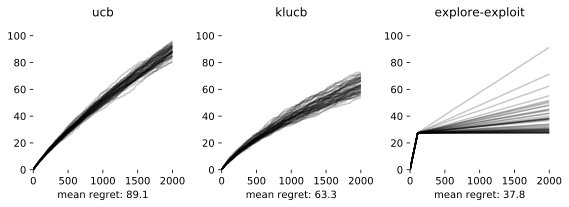

In [27]:
r = lambda x: x
F = lambda x: x
sampler = lambda: random.random()

xstar, M = best_action_value(F, r)

f, ax = plt.subplots(1, 3, figsize=(8, 3))

T = 2000
K = int(2 * max(1, (T / math.log(T))**0.25 + 1))
print("K = {}".format(K))

nrep = 50

# algos
for i, policy in enumerate([ucb, klucb]):
    regrets, actions = abandonment_simulation(T, K, F, r, policy, nrep=nrep)
    plot_regrets(regrets, ax=ax[i], title=policy.__name__)
    
# explore-exploit
regrets = oracle_simulations(explore_exploit, T, F, r, sampler, nrep)
plot_regrets(regrets, ax=ax[-1], title="explore-exploit")

for a in ax:
    a.set_ylim(0, 110)
    a.set_xlim(0, T)
        
f.tight_layout()

# Feedback

In [28]:
def linear_grid(a, b, steps):
    # this is an interior linear grid that does not contain a or b
    stepsize = (b-a)/steps
    return [round(a + (i+0.5) * stepsize, 3) for i in range(steps)]

# value iteration operator
def l2_dist(a, b):
    return sum((v - b[x][0])**2 for x, (v, _) in a.items()) / len(a)

def vi(initial, operator, converged):
    def _vi(old, new):
        if converged(old, new):
            return new
        return _vi(new, operator(new))
    
    return _vi(initial, operator(initial))

In [29]:
# some distribution functions
def Funif(x):
    return max(min(x, 1), 0)

def Fbetab(x, b):
    return 1 - (1-x)**b

# some reward functions
linear = lambda x: x
neglog = lambda x: -math.log(1-x)

steps = 201


In [30]:
def Vop(F, grid, r=lambda x: x, beta=1, discount=0.9):
    def Fcond(y, a, b):
        nom = F(y) - F(a)
        denom = F(b) - F(a)
        if denom > 0:
            return nom / denom
        return 0
    
    def _Vop(xvx):
        def v(y, a, b):
            prob_success = 1-Fcond(y, a, b)
            val_success = r(y) + discount * xvx[(y, b)][0]
            val_fail = beta * discount * xvx[(a, y)][0]
            return prob_success * val_success + (1-prob_success) * val_fail
    
        def Vnew(state):
            a, b = state
            return max(((v(y, a, b), y) for y in grid if a <= y < b), default=(0, 0))
        
        return {state: Vnew(state) for state, Vstate in xvx.items()}
    
    return _Vop

In [31]:
def analyze_vopt(F=Funif, grid=linear_grid(0, 1, steps), reward_fn=linear, beta=1, discount=0.8, tol=1e-3):
    vopt = compute_vopt(F, grid, reward_fn, beta, discount, tol)
#     _ = plot_vopt(vopt, grid, discount)
    return vopt

def compute_vopt(F=Funif, grid=linear_grid(0, 1, steps), reward_fn=linear, beta=1, discount=0.8, tol=1e-5):
    initial = {(x, y): (0, 0) for x in grid for y in grid if x <= y}
    return vi(initial, Vop(F, grid, reward_fn, beta=beta, discount=discount), lambda x, y: l2_dist(x, y) < tol)



In [32]:
# extracting optimal actions

grid = linear_grid(0, 1, steps)
lb, ub = grid[0], grid[-1]

def action(vopt, lower, upper):
    v, y = vopt[(lower, upper)]
    return y
    
def action_tree(vopt, init_lower, init_upper):
    y = action(vopt, init_lower, init_upper)
    if y == init_lower:
        return y
    return y, action_tree(vopt, init_lower, y), action_tree(vopt, y, init_upper)

# code to plot the action tree

def left(tree):
    return tree[1]

def right(tree):
    return tree[2]

def value(tree):
    if isinstance(tree, tuple):
        return tree[0]
    return tree

In [33]:
def plot_line(axes, a, b, style="r-", alpha=1.0, x_offset=0):
    axes.plot([a[0]+x_offset, b[0]-x_offset], [a[1], b[1]], style, alpha=alpha)
    axes.plot([a[0]], [a[1]], "k. ")


def plot_node(axes, tree, index=0, depth=10, x_offset=0):
    if isinstance(tree, tuple) and index < depth:
        plot_line(axes, (index, value(tree)), (index+1, value(left(tree))), style="r--", x_offset=x_offset)
        plot_line(axes, (index, value(tree)), (index+1, value(right(tree))), style="g-", x_offset=x_offset)
#         axes.plot([index, index+1], [value(tree), value(left(tree))], color="darkred")
#         axes.plot([index, index+1], [value(tree), value(right(tree))], color="steelblue")
        plot_node(axes, left(tree), index+1, depth)
        plot_node(axes, right(tree), index+1, depth)
    else:
        plot_line(axes, (index, value(tree)), (depth, value(tree)), style="k:", alpha=0.8, x_offset=x_offset)
#         axes.plot([index, depth], [value(tree), value(tree)], 
#                   color="black", opacity=0.5)

def plot_tree(tree, width=6, height=4, depth=10):
    f, ax = plt.subplots(figsize=(width, height))
    
    ax.set_ylim(0, 1)
    ax.set_title("Visualization of the optimal policy tree")
    ax.set_xlabel("time step t")
    ax.set_ylabel("action at time t x(t)")
    
    for i in range(depth+1): ax.axvline(i, color="black", alpha=0.1)

    plot_node(ax, tree, depth=depth)
    return f, ax

def plot_actions(vopt, lb, ub, depth=10):
    tree = action_tree(vopt, lb, ub)
    c, a = plot_tree(tree, depth=depth)
    return c, a

def plot_vopt(vopt, grid, discount):
    vopt_list = [(a, b, v) for (a, b), (v, y) in vopt.items()]

    canvas = tp.Canvas(500, 400)
    axes = canvas.cartesian()


    axes.plot([0, 1], [0, 1])

    for lower in grid:
        sublist = [(b, (1-discount)*v) for a, b, v in vopt_list if a == lower and b != lower]
        try:
            X, V = zip(*sublist)

            axes.plot(X, V, color="black", opacity=0.5)
        except ValueError:
            pass
        
    return canvas, axes

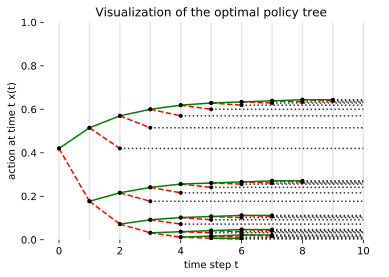

In [34]:
vopt = analyze_vopt(discount=0.9, beta=0.5)
f, ax = plot_actions(vopt, lb, ub)

In [35]:
discount = 0.8
beta_path = [(beta,
              compute_vopt(Funif, 
                           linear_grid(0, 1, steps), 
                           reward_fn=linear, 
                           beta=beta, 
                           discount=discount, 
                           tol=1e-2))
  for beta in linear_grid(0, 1, 31)]

action_path = [(beta, action(vopt, lb, ub)) for beta, vopt in beta_path]
value_path = [(beta, vopt[(lb, ub)][0]) for beta, vopt in beta_path]

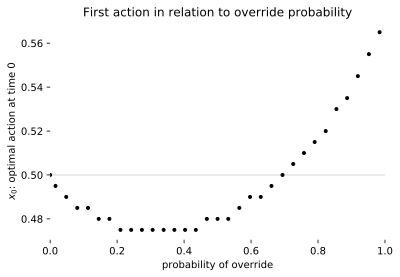

In [36]:
f, ax = plt.subplots(figsize=(6, 4))
ax.set_title("First action in relation to override probability")
ax.set_xlabel("probability of override") 
ax.set_ylabel(r"$x_0$: optimal action at time 0")

ax.set_xlim(0, 1)

x, y = zip(*action_path)
ax.plot([0] + list(x) , [0.5] + list(y), "k. ")
ax.axhline(0.5, color="k", alpha=0.1)